In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaincc
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import norm
import emcee
import multiprocessing
import random
import time
import threading

## fit to line weighted + pearson

(A) Best Fit Parameters:
a = -3.4503 +/- 0.2717
b = 0.2720 +/- 0.0432

Covariance and Correlation:
cov(a,b) = -0.0113
r_ab (corr. coeff) = -0.9642

Goodness of Fit:
Chi-squared         = 19.93
Degrees of freedom  = 17
Reduced Chi-squared = 1.17
Q (p-value)         = 2.7793742059e-01

Pearson Correlation:
r       = 0.8267
p-value = 1.2780e-05


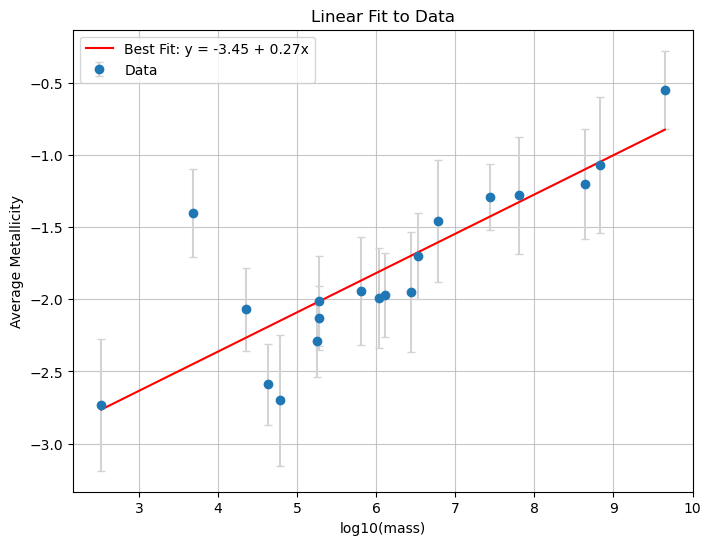

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaincc
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import norm


def load_data(filename):
    data = np.loadtxt(filename)
    x = data[:, 0]
    y = data[:, 1]
    sigma_y = data[:, 3]
    return x, y, sigma_y


def linear_fit_weighted(x, y, sigma_y):
    """
    Perform a weighted linear fit of the form y = a + b*x,
    given data points (x_i, y_i) with errors sigma_y_i.

    Parameters:
    -----------
    x : ndarray
        Independent variable values.
    y : ndarray
        Dependent variable values.
    sigma_y : ndarray
        Errors (1-sigma) on y-values.

    Returns:
    --------
    a : float
        Best-fit intercept.
    b : float
        Best-fit slope.
    sigma_a : float
        Uncertainty in best-fit intercept.
    sigma_b : float
        Uncertainty in best-fit slope.
    cov_ab : float
        Covariance between a and b.
    r_ab : float
        Correlation coefficient between a and b.
    chi_squared : float
        Chi-squared of the fit.
    dof : int
        Degrees of freedom (N - number_of_parameters).
    Q : float
        Goodness-of-fit p-value based on Chi-squared distribution.
    """
    # Number of data points
    N = len(x)
    
    # sums needed for linear regression
    weights = 1 / sigma_y**2
    S = np.sum(weights)
    Sx = np.sum(x * weights)
    Sy = np.sum(y * weights)
    Sxx = np.sum(x**2 * weights)
    Sxy = np.sum(x * y * weights)
    
    # Fit parameters (a = intercept, b = slope)
    delta = S * Sxx - Sx**2
    a = (Sxx * Sy - Sx * Sxy) / delta
    b = (S * Sxy - Sx * Sy) / delta
    
    # Parameter uncertainties and covariance
    sigma_a = np.sqrt(Sxx / delta)
    sigma_b = np.sqrt(S / delta)
    cov_ab = -Sx / delta
    # Correlation coefficient between a and b
    r_ab = cov_ab / (sigma_a * sigma_b)
    
    # Chi-squared
    y_model = a + b * x
    chi_squared = np.sum(((y - y_model) / sigma_y)**2)
    dof = N - 2  # For a two-parameter fit

    # Goodness-of-fit
    Q = gammaincc(dof / 2, chi_squared / 2)
    
    return a, b, sigma_a, sigma_b, cov_ab, r_ab, chi_squared, dof, Q


def print_fit_results(a, b, sigma_a, sigma_b, cov_ab, r_ab, chi_squared, dof, Q):
    print("(A) Best Fit Parameters:")
    print(f"a = {a:.4f} +/- {sigma_a:.4f}")
    print(f"b = {b:.4f} +/- {sigma_b:.4f}")
    
    print("\nCovariance and Correlation:")
    print(f"cov(a,b) = {cov_ab:.4f}")
    print(f"r_ab (corr. coeff) = {r_ab:.4f}\n")
    
    reduced_chi_squared = chi_squared / dof
    print("Goodness of Fit:")
    print(f"Chi-squared         = {chi_squared:.2f}")
    print(f"Degrees of freedom  = {dof}")
    print(f"Reduced Chi-squared = {reduced_chi_squared:.2f}")
    print(f"Q (p-value)         = {Q:.10e}\n")


def plot_data_and_fit(x, y, sigma_y, a, b, xlabel='log10(mass)', ylabel='Average Metallicity'):
    """
    Plot the data with error bars and the linear fit.
    
    Parameters:
    -----------
    x, y, sigma_y : ndarray
        Data points and their errors.
    a, b : float
        Best-fit intercept and slope.
    xlabel, ylabel : str
        Labels for the x and y axes.
    """
    # x-range for plotting the fit
    x_fit = np.linspace(min(x), max(x), 1000)
    y_fit = a + b * x_fit
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(x, y, yerr=sigma_y, fmt='o', label='Data', 
                 ecolor='lightgray', capsize=3)
    plt.plot(x_fit, y_fit, 'r-', label=f'Best Fit: y = {a:.2f} + {b:.2f}x')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Linear Fit to Data')
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()


def main(filename='mmr_lg.dat'):
  
    x, y, sigma_y = load_data(filename)
    
    # linear fit
    a, b, sigma_a, sigma_b, cov_ab, r_ab, chi_squared, dof, Q = linear_fit_weighted(x, y, sigma_y)
    
    
    print_fit_results(a, b, sigma_a, sigma_b, cov_ab, r_ab, chi_squared, dof, Q)
    # pearson correlation
    r, p_value = pearsonr(x, y)
    print("Pearson Correlation:")
    print(f"r       = {r:.4f}")
    print(f"p-value = {p_value:.4e}")
    
    plot_data_and_fit(x, y, sigma_y, a, b, xlabel='log10(mass)', ylabel='Average Metallicity')
    
    
    
if __name__ == "__main__":
    main()


## metropolis hastings

NumPy std = 15.6573; NumPy mean = 6.7125
Proposed noise_std = 15.581; noise_mean = 6.665
Final std: 15.6573; Final mean: 6.7125
Acceptance Rate: 0.95
MCMC Estimated mean: 6.7371 -- NumPy mean: 6.7125
MCMC Estimated std:  15.6900 -- NumPy std:  15.6573


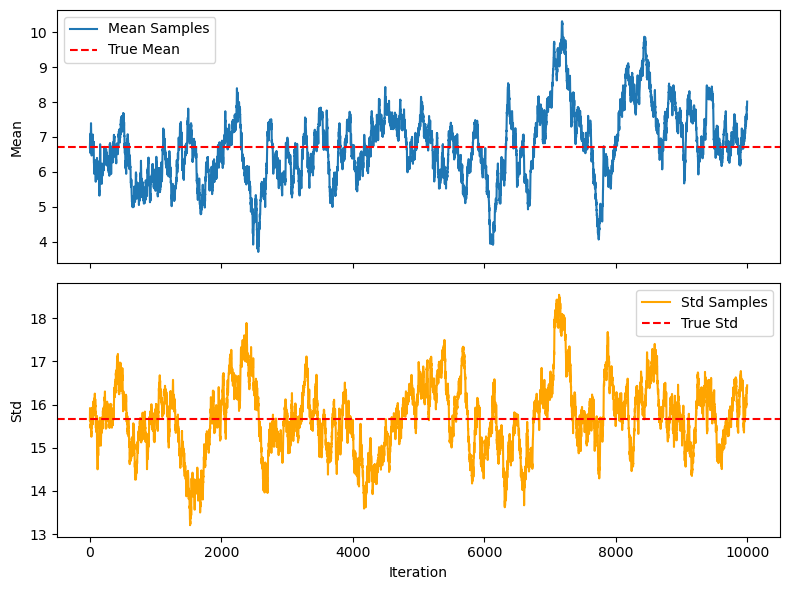

In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def load_data(filename):
    data = np.loadtxt(filename)
    return data


def compute_numpy_stats(data):
    mean_numpy = np.mean(data)
    std_numpy = np.std(data)
    return mean_numpy, std_numpy


def sample_proposed_stats(mean_numpy, std_numpy, noise_scale=0.1):
    """
    Propose new mean and std from Gaussian distributions
    centered on the original NumPy stats and decide whether to keep
    them based on likelihood comparisons.
    """
    # Propose new standard deviation and mean
    noise_std = norm(std_numpy, noise_scale).rvs()
    noise_mean = norm(mean_numpy, noise_scale).rvs()

    print(f"Proposed noise_std = {noise_std:.3f}; noise_mean = {noise_mean:.3f}")

    # Likelihood of the proposed stats
    likelihood_new_std = norm(std_numpy, noise_scale).pdf(noise_std)
    likelihood_new_mean = norm(mean_numpy, noise_scale).pdf(noise_mean)

    # Likelihood of the original stats (treated as the "old" ones)
    likelihood_old_std = norm(std_numpy, noise_scale).pdf(std_numpy)
    likelihood_old_mean = norm(mean_numpy, noise_scale).pdf(mean_numpy)

    # Choose whichever has higher likelihood
    final_std = noise_std if likelihood_new_std > likelihood_old_std else std_numpy
    final_mean = noise_mean if likelihood_new_mean > likelihood_old_mean else mean_numpy

    return final_std, final_mean


def run_mcmc(data, num_iterations=10000, sigma_m=0.1):
    """
    returns
    acceptance_rate : float
        The fraction of proposed updates that were accepted.
    mean_samples : list
        Samples of the mean after each iteration.
    std_samples : list
        Samples of the standard deviation after each iteration.
    """
    # Initialize current parameters
    current_mean = np.mean(data)
    current_std = np.std(data)
    accepted = 0

    mean_samples = []
    std_samples = []

    # Current log-likelihood
    log_likelihood_current = np.sum(norm(current_mean, current_std).logpdf(data))

    for _ in range(num_iterations):
        # Propose new mean and std from normal distributions
        proposed_mean = norm(current_mean, sigma_m).rvs()
        proposed_std = norm(current_std, sigma_m).rvs()

        # Ensure std > 0
        if proposed_std <= 0:
            mean_samples.append(current_mean)
            std_samples.append(current_std)
            continue

        # Compute log-likelihood for proposed
        log_likelihood_proposed = np.sum(norm(proposed_mean, proposed_std).logpdf(data))

        # Acceptance probability
        acceptance_prob = np.exp(log_likelihood_proposed - log_likelihood_current)

        # Accept or reject
        if np.random.rand() < acceptance_prob:
            current_mean = proposed_mean
            current_std = proposed_std
            log_likelihood_current = log_likelihood_proposed
            accepted += 1

        # Store samples
        mean_samples.append(current_mean)
        std_samples.append(current_std)

    acceptance_rate = accepted / num_iterations
    return acceptance_rate, mean_samples, std_samples


def main():
    data = load_data('input_data.txt')
    
    mean_numpy, std_numpy = compute_numpy_stats(data)
    print(f"NumPy std = {std_numpy:.4f}; NumPy mean = {mean_numpy:.4f}")

    # sample 
    final_std, final_mean = sample_proposed_stats(mean_numpy, std_numpy, noise_scale=0.1)
    print(f"Final std: {final_std:.4f}; Final mean: {final_mean:.4f}")

    #MCMC
    acceptance_rate, mean_samples, std_samples = run_mcmc(data, num_iterations=10000, sigma_m=0.1)
    print(f"Acceptance Rate: {acceptance_rate:.2f}")

    # 5. Compute MCMC-based estimates
    estimated_mean = np.mean(mean_samples)
    estimated_std = np.mean(std_samples)
    print(f"MCMC Estimated mean: {estimated_mean:.4f} -- NumPy mean: {mean_numpy:.4f}")
    print(f"MCMC Estimated std:  {estimated_std:.4f} -- NumPy std:  {std_numpy:.4f}")

    #  MCMC traces
    plot_traces(mean_samples, std_samples)


def plot_traces(mean_samples, std_samples):
    data = load_data('input_data.txt')
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    axes[0].plot(mean_samples, label='Mean Samples')
    axes[0].axhline(np.mean(data), color='red', linestyle='--', label='True Mean')
    axes[0].set_ylabel('Mean')
    axes[0].legend()

    axes[1].plot(std_samples, label='Std Samples', color='orange')
    axes[1].axhline(np.std(data), color='red', linestyle='--', label='True Std')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Std')
    axes[1].legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


## line fitting 3x methods 

In [5]:
import numpy as np
from numpy.polynomial import Polynomial
from scipy.stats import linregress
from scipy.optimize import curve_fit

def load_data(filename):
    """
    Loads x, y, and optional sigma_y from a data file.
    Adjust indices if needed (or omit sigma_y if not available).

    Parameters
    ----------
    filename : str
        Path to the data file.

    Returns
    -------
    x : ndarray
        Independent variable values.
    y : ndarray
        Dependent variable values.
    sigma_y : ndarray or None
        Errors on y, if available. Otherwise, return None or an array of ones.
    """
    data = np.loadtxt(filename)
    x = data[:, 0]
    y = data[:, 1]

    # If the 3rd column is error in y:
    # (Adjust based on your actual data file structure)
    if data.shape[1] > 2:
        sigma_y = data[:, 2]
    else:
        sigma_y = None

    return x, y, sigma_y


def numpy_polynomial_fit(x, y, deg=1):
    """
    Fit data using numpy.polynomial.Polynomial.fit

    Parameters
    ----------
    x : ndarray
        Independent variable
    y : ndarray
        Dependent variable
    deg : int
        Polynomial degree (1 for a linear fit)

    Returns
    -------
    slope : float
    intercept : float
    """
    poly = Polynomial.fit(x, y, deg=deg)
    # Convert to standard polynomial coefficients (lowest power first)
    coef = poly.convert().coef
    # For a linear polynomial: coef[0] = intercept, coef[1] = slope
    slope = coef[1]
    intercept = coef[0]
    return slope, intercept


def scipy_linregress_fit(x, y):
    """
    Fit data using scipy.stats.linregress

    Parameters
    ----------
    x : ndarray
        Independent variable
    y : ndarray
        Dependent variable

    Returns
    -------
    slope : float
    intercept : float
    r_value : float
    p_value : float
    std_err : float
    """
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value, p_value, std_err


def linear_model(x, a, b):
    return a * x + b


def scipy_curve_fit_linear(x, y, sigma_y=None):
    """
    Fit data using scipy.optimize.curve_fit with a linear model.

    Parameters
    ----------
    x : ndarray
        Independent variable
    y : ndarray
        Dependent variable
    sigma_y : ndarray or None
        Errors in y. If None, curve_fit will assume equal weights.

    Returns
    -------
    a_cf : float
        Best-fit slope
    b_cf : float
        Best-fit intercept
    sigma_a_cf : float
        Standard deviation (uncertainty) of slope
    sigma_b_cf : float
        Standard deviation (uncertainty) of intercept
    """
    # If sigma_y is None, pass absolute_sigma=False or an array of ones
    if sigma_y is None:
        popt, pcov = curve_fit(linear_model, x, y)
    else:
        popt, pcov = curve_fit(linear_model, x, y, sigma=sigma_y, absolute_sigma=True)

    a_cf, b_cf = popt
    # Diagonal elements of pcov are the variances of the parameters
    sigma_a_cf, sigma_b_cf = np.sqrt(np.diag(pcov))
    return a_cf, b_cf, sigma_a_cf, sigma_b_cf


def main():

    filename = "mmr_lg.dat"
    x, y, sigma_y = load_data(filename)

    # 2. numpy Polynomial.fit
    a_np, b_np = numpy_polynomial_fit(x, y, deg=1)
    print("NumPy Polynomial.fit results:")
    print(f"Slope (a)     = {a_np:.4f}")
    print(f"Intercept (b) = {b_np:.4f}\n")

    # 3. scipy.stats.linregress
    slope_lin, intercept_lin, r_value, p_value, std_err = scipy_linregress_fit(x, y)
    print("scipy.stats.linregress results:")
    print(f"Slope (a)     = {slope_lin:.4f} ± {std_err:.4f}")
    print(f"Intercept (b) = {intercept_lin:.4f}")
    print(f"Pearson's r   = {r_value:.4f}")
    print(f"P-value       = {p_value:.4e}\n")

    # 4. scipy.optimize.curve_fit
    a_cf, b_cf, sigma_a_cf, sigma_b_cf = scipy_curve_fit_linear(x, y, sigma_y)
    print("scipy.optimize.curve_fit results:")
    print(f"Slope (a)     = {a_cf:.4f} ± {sigma_a_cf:.4f}")
    print(f"Intercept (b) = {b_cf:.4f} ± {sigma_b_cf:.4f}")


if __name__ == "__main__":
    main()


NumPy Polynomial.fit results:
Slope (a)     = 0.2651
Intercept (b) = -3.4226

scipy.stats.linregress results:
Slope (a)     = 0.2651 ± 0.0438
Intercept (b) = -3.4226
Pearson's r   = 0.8267
P-value       = 1.2780e-05

scipy.optimize.curve_fit results:
Slope (a)     = 0.2492 ± 0.0079
Intercept (b) = -3.3851 ± 0.0461


## MCMC std/mean


In [6]:
import emcee

def log_likelihood(theta, data):
    """
    Computes the log-likelihood for a normal distribution.
    ----------
    theta : tuple or list
        Model parameters (mu, sigma).
    data : ndarray
        Observed data.
    ------ returns -------
    ll : float
        The log of the likelihood function.
    """
    mu, sigma = theta
    # If sigma <= 0, the likelihood is undefined; return -∞
    if sigma <= 0:
        return -np.inf

    n = len(data)
    return -0.5 * np.sum(((data - mu)**2) / sigma**2 + np.log(2.0 * np.pi * sigma**2))


def log_prior(theta):
    """
    Defines the prior distribution on parameters.
    ----------
    theta : tuple or list
        Model parameters (mu, sigma).
    ------- returns -------
    lp : float
        The log of the prior distribution.
    """
    mu, sigma = theta
    # Example: uniform priors for mu in (-1000, 1000) and sigma in (0, 1000)
    # Return -∞ if outside bounds.
    if -1000 < mu < 1000 and 0 < sigma < 1000:
        return 0.0  # log(1) = 0, meaning a flat prior
    else:
        return -np.inf


def log_probability(theta, data):
    """
    Computes the posterior log-probability = log_prior + log_likelihood.
    ----------
    theta : tuple or list
        Model parameters (mu, sigma).
    data : ndarray
        Observed data.
     ------ returns -------
    lp : float
        Posterior log-probability.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)


def run_mcmc(data, nwalkers=50, nsteps=20000, discard=500, thin=10):
    """
    Set up and run an MCMC sampler with emcee for the normal model.

    Parameters
    ----------
    data : ndarray
        Observed data.
    nwalkers : int
        Number of walkers in the ensemble.
    nsteps : int
        Number of MCMC steps.
    discard : int
        Number of initial steps (burn-in) to discard.
    thin : int
        Thinning factor (use every 'thin'-th sample).
    ------- returns -------
    flat_samples : ndarray
        The MCMC samples (post burn-in and thinning).
    sampler : emcee.EnsembleSampler
        The sampler object containing the entire chain (if needed).
    """
    # Initial guesses for (mu, sigma) based on data
    mu_guess = np.mean(data)
    sigma_guess = np.std(data)

    ndim = 2  # (mu, sigma)
    pos = np.array([mu_guess, sigma_guess]) + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data,))
    sampler.run_mcmc(pos, nsteps, progress=True) # fancy progress bar

    # Flatten chain after discarding burn-in and applying thinning
    flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
    return flat_samples, sampler


def main(filename='input_data.txt'):
    data = np.loadtxt(filename)

    flat_samples, sampler = run_mcmc(data, 
                                     nwalkers=50, 
                                     nsteps=10000, 
                                     discard=500, 
                                     thin=10)

    # 3. Analyze results
    #    - Posterior means
    #    - Posterior standard deviations
    m_mu, m_sigma = np.mean(flat_samples, axis=0)
    sd_mu, sd_sigma = np.std(flat_samples, axis=0)

    # 4. Compare with NumPy estimates (just to check)
    mean_numpy = np.mean(data)
    std_numpy = np.std(data)

    print("\n--- MCMC Results ---")
    print(f"MCMC Mean: {m_mu:.4f} ± {sd_mu:.4f}")
    print(f"MCMC Std:  {m_sigma:.4f} ± {sd_sigma:.4f}")
    print("\n--- NumPy Estimates ---")
    print(f"NumPy Mean: {mean_numpy:.4f}")
    print(f"NumPy Std:  {std_numpy:.4f}\n")


if __name__ == "__main__":
    main()


100%|██████████| 10000/10000 [00:06<00:00, 1580.39it/s]


--- MCMC Results ---
MCMC Mean: 6.7149 ± 1.1152
MCMC Std:  15.7868 ± 0.7963

--- NumPy Estimates ---
NumPy Mean: 6.7125
NumPy Std:  15.6573



## threading 

In [7]:
def estimate_pi_threaded(total_particles=10_000_000, 
                         num_threads=6, 
                         x_min=0, 
                         x_max=1, 
                         y_min=0, 
                         y_max=1):
    """
    Estimate π using Monte Carlo simulation in a quarter circle
    (in the unit square [0,1] x [0,1] by default),
    parallelized using multiple threads.

    Parameters
    ----------
    total_particles : int
        Total number of random points to sample.
    num_threads : int
        Number of threads to use.
    x_min, x_max : float
        Bounds of the x-dimension.
    y_min, y_max : float
        Bounds of the y-dimension.

    Returns
    -------
    total_particles : int
        The total number of points sampled.
    pi_estimate : float
        The estimated value of π.
    elapsed_time : float
        The total time taken for the simulation.
    """
    # We assume a circle of diameter = (x_max - x_min) 
    # so radius is half of that span.
    radius = (x_max - x_min) / 2
    center = x_min + radius
    
    # Divide work among threads
    particles_per_thread = total_particles // num_threads
    remaining_particles = total_particles % num_threads
    
    # Shared results
    counts = []
    lock = threading.Lock()
    
    def worker(n_particles):
        """
        Worker function to be executed by each thread.
        Samples n_particles within the square and counts how many 
        fall within the circle defined by the radius and center.
        """
        x = np.random.uniform(x_min, x_max, n_particles)
        y = np.random.uniform(y_min, y_max, n_particles)
        distances_squared = (x - center)**2 + (y - center)**2
        n_inside = np.sum(distances_squared <= radius**2)
        with lock:
            counts.append(n_inside)
    
    # Start timing
    start_time = time.time()
    
    # Create and start threads
    threads = []
    for i in range(num_threads):
        # Give leftover particles to the last thread
        if i == num_threads - 1:
            n_particles = particles_per_thread + remaining_particles
        else:
            n_particles = particles_per_thread
        
        thread = threading.Thread(target=worker, args=(n_particles,))
        threads.append(thread)
        thread.start()
    
    # Wait for all threads to finish
    for thread in threads:
        thread.join()
    
    total_inside = sum(counts)
    
    # Area-based estimate: (area of square) * (# inside circle / # total)
    # For a circle with radius 'r', area = πr^2, 
    # but since the square is from 0 to 1, we interpret 
    # this as if it’s a quarter circle if x_min=0, y_min=0, 
    # x_max=1, y_max=1. 
    # More generally, area_of_square = (x_max - x_min) * (y_max - y_min).
    #
    # However, the common approach for a quarter circle is
    # π = 4 * (# inside / # total).
    # This only works strictly if you are actually sampling 
    # a square that encloses a quarter circle. 
    #
    # If your bounding box is the entire circle's bounding box (0..1, 0..1), 
    # the classic formula is π = 4 * inside / total 
    # *assuming radius=0.5, and you treat the region as a quarter circle.
    # 
    # Adjust if you are doing a different region.

    pi_estimate = 4.0 * total_inside / total_particles  
    elapsed_time = time.time() - start_time
    
    return total_particles, pi_estimate, elapsed_time


def main():
    total_particles = 10_000_000
    num_threads = 6
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1

    # Run the threaded Monte Carlo simulation
    particles, pi_est, time_elapsed = estimate_pi_threaded(
        total_particles=total_particles,
        num_threads=num_threads,
        x_min=x_min,
        x_max=x_max,
        y_min=y_min,
        y_max=y_max
    )

    # Print the results
    print(f"Particles:   {particles}")
    print(f"Estimated π: {pi_est}")
    print(f"Time elapsed: {time_elapsed:.2f} seconds")


if __name__ == "__main__":
    main()


Particles:   10000000
Estimated π: 3.1412888
Time elapsed: 0.15 seconds


## hydro equation 1. ex.

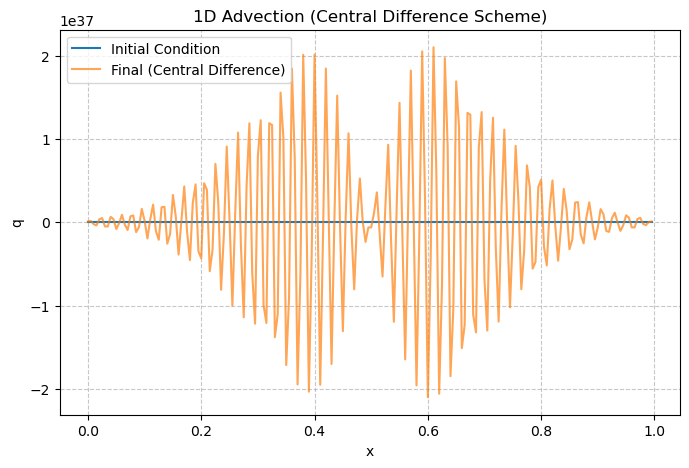

In [18]:
def define_spatial_domain(L=1.0, N=200):
    """ spatial domain for the PDE.
    L : float
        Length of the domain.
    N : int
        Number of grid points.
    -------Returns-------
    x : ndarray
        Array of x-coordinates (cell centers).
    dx : float
        Spatial resolution (distance between grid points).
    """
    x = np.linspace(0, L, N, endpoint=False)
    dx = L / N
    return x, dx

def define_time_step(dx, c=1.0, cfl=0.5, total_time=2.0):
    """    Defines the time step from a CFL condition and
    calculates the number of steps.
    dx : float
        Spatial resolution.
    c : float
        Advection speed.
    cfl : float
        Desired CFL number (<= 1 for stability in many schemes).
    total_time : float
        Total simulation time.

    Returns
    -------
    dt : float
        Time step size.
    n_steps : int
        Number of time steps to cover total_time.
    """
    dt = cfl * dx / c  # e.g., dt = 0.5 * dx / c
    n_steps = int(total_time / dt)
    return dt, n_steps

def initial_condition_step(x, start=0.4, end=0.6):
    """   Initializes a step function as the initial condition:
    q(x) = 1 for x in [start, end), otherwise 0.
    x : ndarray
        Coordinates of the domain.
    start : float
        Left boundary of the step region.
    end : float
        Right boundary of the step region.
    -------Returns-------
    q0 : ndarray
        Initial condition array.
    """
    q0 = np.zeros_like(x)
    mask = (x >= start) & (x < end)
    q0[mask] = 1.0
    return q0

def central_difference_step(q, c, dt, dx):
    """    Performs one time step of the central difference scheme 
    for the 1D advection equation q_t + c*q_x = 0
    with periodic boundary conditions.
    ----------
    q : ndarray
        Current solution array of shape (N,).
    c : float
        Advection speed.
    dt : float
        Time step size.
    dx : float
        Spatial resolution.
    -------Returns----------
    q_new : ndarray
        Updated solution array after one central difference step.
    """
    N = len(q)
    q_new = q.copy()

    # Central difference for interior points
    for i in range(1, N-1):
        q_new[i] = q[i] - (c * dt / (2*dx)) * (q[i+1] - q[i-1])
    
    # Periodic boundary conditions:
    # Left boundary (i=0) uses q[-1] as the "left neighbor"
    q_new[0]  = q[0]  - (c * dt / (2*dx)) * (q[1] - q[-1])
    # Right boundary (i=N-1) uses q[0] as the "right neighbor"
    q_new[-1] = q[-1] - (c * dt / (2*dx)) * (q[0] - q[-2])

    return q_new

def solve_advection_1D(x, q0, c, dt, n_steps):
    """    Solves the 1D advection equation using a central difference scheme.
    x : ndarray
        Spatial coordinates.
    q0 : ndarray
        Initial condition.
    c : float
        Advection speed.
    dt : float
        Time step size.
    n_steps : int
        Number of time steps.
    -------Returns----------
    q : ndarray
        Numerical solution at the final time step.
    """
    q = q0.copy()
    for _ in range(n_steps):
        q = central_difference_step(q, c, dt, x[1] - x[0])
    return q

def main():
    # Parameters
    L = 1.0
    N = 200
    c = 1.0
    total_time = 2.0
    cfl = 0.5

    #  spatial domain
    x, dx = define_spatial_domain(L=L, N=N)
    
    # time step
    dt, n_steps = define_time_step(dx, c=c, cfl=cfl, total_time=total_time)
    
    #  initial condition
    q0 = initial_condition_step(x, start=0.4, end=0.6)
    
    #b solve
    q_final = solve_advection_1D(x, q0, c, dt, n_steps)
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, q0, label='Initial Condition')
    plt.plot(x, q_final, label='Final (Central Difference)', alpha=0.7)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('q')
    plt.title('1D Advection (Central Difference Scheme)')
    plt.grid(alpha=0.7, ls='--')
    plt.show()

if __name__ == "__main__":
    main()


## upstream schenme

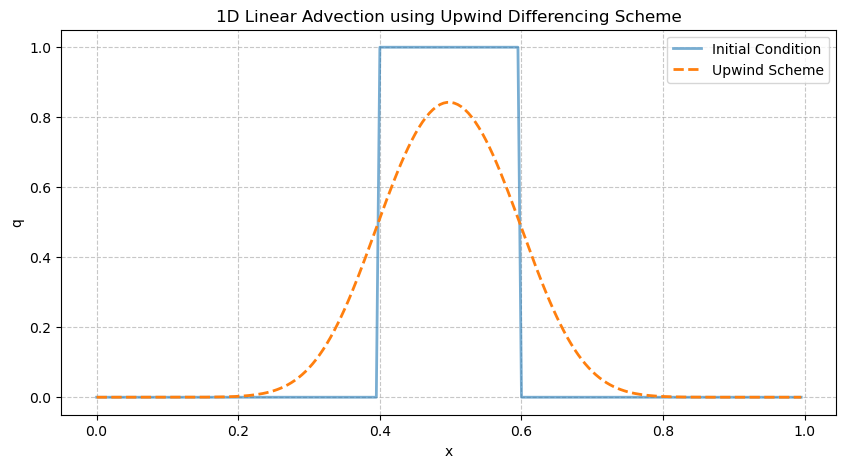

In [24]:
def define_spatial_domain(L=1.0, N=200):
    """    Defines the spatial domain for the PDE.
    L : float
        Length of the domain.
    N : int
        Number of grid points.
    -------Returns---------
    x : ndarray
        Array of x-coordinates (cell centers).
    dx : float
        Spatial resolution (distance between grid points).
    """
    x = np.linspace(0, L, N, endpoint=False)
    dx = L / N
    return x, dx


def define_time_step(dx, c=1.0, cfl=0.5, total_time=2.0):
    """    Defines the time step from a CFL condition and
    calculates the number of steps.
    dx : float
        Spatial resolution.
    c : float
        Advection speed.
    cfl : float
        Desired CFL number.
    total_time : float
        Total simulation time.
    -------Returns---------
    dt : float
        Time step size.
    n_steps : int
        Number of time steps to cover total_time.
    """
    dt = cfl * dx / c  
    n_steps = int(total_time / dt)
    return dt, n_steps


def initial_condition_step(x, start=0.4, end=0.6):
    """    Initializes a step function as the initial condition:
    q(x) = 1 for x in [start, end), otherwise 0.
    x : ndarray
        Coordinates of the domain.
    start : float
        Left boundary of the step region.
    end : float
        Right boundary of the step region.
    -------Returns---------
    q0 : ndarray
        Initial condition array.
    """
    q0 = np.zeros_like(x)
    q0[(x >= start) & (x < end)] = 1.0
    return q0


def upwind_step(q, c, dt, dx):
    """    Performs one time step of the upwind (upstream) scheme for the 1D advection equation
    q_t + c*q_x = 0, with periodic boundary conditions.
    q : ndarray
        Current solution array of shape (N,).
    c : float
        Advection speed.
    dt : float
        Time step size.
    dx : float
        Spatial resolution.
    -------Returns---------
    q_new : ndarray
        Updated solution array after one upwind step.
    """
    N = len(q)
    q_new = q.copy()

    # Upwind differencing for interior points
    # q_{i}^{n+1} = q_{i}^{n} - (c * dt / dx) * [q_{i}^{n} - q_{i-1}^{n}]
    for i in range(1, N):
        q_new[i] = q[i] - (c * dt / dx) * (q[i] - q[i-1])

    # Periodic boundary condition for i = 0 
    # (using q[-1] as the "left neighbor")
    q_new[0] = q[0] - (c * dt / dx) * (q[0] - q[-1])

    return q_new


def solve_advection_1D_upwind(x, q0, c, dt, n_steps):
    """    Solves the 1D advection equation using an upwind scheme.
    x : ndarray
        Spatial coordinates.
    q0 : ndarray
        Initial condition.
    c : float
        Advection speed.
    dt : float
        Time step size.
    n_steps : int
        Number of time steps.
    -------Returns---------
    q : ndarray
        Numerical solution at the final time step.
    """
    q = q0.copy()
    dx = x[1] - x[0]
    for _ in range(n_steps):
        q = upwind_step(q, c, dt, dx)
    return q


def main():

    L = 1.0
    N = 200
    c = 1.0
    total_time = 2.0
    cfl = 0.5

    x, dx = define_spatial_domain(L=L, N=N)

    dt, n_steps = define_time_step(dx, c=c, cfl=cfl, total_time=total_time)
    
    # initial condition
    q0 = initial_condition_step(x, start=0.4, end=0.6)
    
    
    q_final = solve_advection_1D_upwind(x, q0, c, dt, n_steps)
    
    # 5. Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(x, q0, label='Initial Condition', linewidth=2, alpha=0.6)
    plt.plot(x, q_final, label='Upwind Scheme', linewidth=2, ls='--')
    plt.xlabel('x')
    plt.ylabel('q')
    plt.title('1D Linear Advection using Upwind Differencing Scheme')
    plt.legend()
    plt.grid(alpha=0.7, linestyle='--')
    plt.show()


if __name__ == "__main__":
    main()